# Christofides-Algorithmus für das Traveling Salesman Problem

Der Christofides-Algorithmus, entwickelt von Nicos Christofides im Jahr 1976, ist ein ausgeklügelter Näherungsalgorithmus, der garantiert eine Lösung findet, die höchstens 50% länger ist als die optimale Route. Dies ist ein enormer Fortschritt gegenüber einfacheren Algorithmen wie dem Nearest-Neighbor-Algorithmus, der keine solche Garantie bietet.

Die grundlegende Idee des Algorithmus besteht aus mehreren Schritten:

1. **Minimaler Spannbaum (MST)**: Wir verbinden alle Punkte mit der kürzestmöglichen Gesamtlänge an Verbindungen, ohne Kreise zu bilden.
2. **Ungerade Knoten finden**: Wir identifizieren die Punkte, an denen eine ungerade Anzahl von Verbindungen zusammenkommt.
3. **Minimales perfektes Matching**: Wir verbinden die ungeraden Punkte paarweise so, dass die Gesamtlänge minimal ist.
4. **Multigraph erstellen**: Wir kombinieren den MST und das Matching zu einem neuen Graphen.
5. **Eulerkreis finden**: Wir finden einen Rundweg, der jede Verbindung genau einmal durchläuft.
6. **Hamiltonkreis ableiten**: Wir kürzen diesen Rundweg ab, indem wir wiederholte Punkte überspringen.

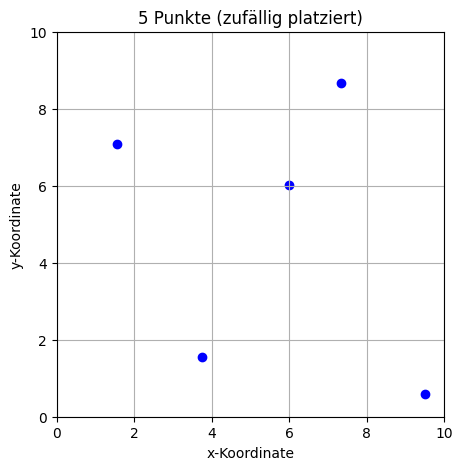

In [16]:
# Vorbereitung: Notwendige Bibliotheken importieren und Testdaten generieren

import numpy as np
import matplotlib.pyplot as plt
import math
import time  # Für Zeitmessungen der Algorithmen

# Hilfsfunktion zum Visualisieren der Punktemenge
def plot():
    plt.figure(figsize=(5, 5))
    plt.scatter(x, y, color='blue')  # Punkte als Scatterplot darstellen
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.grid(True)
    plt.title(f'{number_of_points} Punkte (zufällig platziert)')
    plt.xlabel('x-Koordinate')
    plt.ylabel('y-Koordinate')
    plt.show()

# Für die Reproduzierbarkeit: Feste Zufallszahlen
number_of_points = 5  # Anzahl der Punkte
np.random.seed(42)    # Für reproduzierbare Ergebnisse

# Generiere zufällige Koordinaten im Bereich [0, 10] × [0, 10]
x = np.random.rand(number_of_points) * 10  # x-Koordinaten
y = np.random.rand(number_of_points) * 10  # y-Koordinaten

# Erstelle Liste von Punkten als (x,y)-Koordinatenpaare
points = list(zip(x, y))

# Dictionary für spätere Ergebnisauswertung vorbereiten
algorithm_results = {
    'christofides': {'distance': None, 'time': None, 'operations': None}
}

# Visualisiere die generierten Punkte
plot()

In [17]:
# Zähler für die Operationen im Christofides-Algorithmus initialisieren
christofides_operations = 0

def euclidean(i, j):
    """Berechnet die euklidische Distanz zwischen points[i] und points[j].
    
    Parameter:
      i (int): Index des ersten Punktes in der Liste 'points'
      j (int): Index des zweiten Punktes in der Liste 'points'
    
    Rückgabe:
      float: Euklidische Distanz zwischen den beiden Punkten.
    """
    # Zählen der Distanzberechnung als Operation
    global christofides_operations
    christofides_operations += 1
    # math.dist berechnet die Distanz zwischen zwei iterierbaren Objekten, z.B. Tupel
    return math.dist(points[i], points[j])

# Vereinfachte Distanzfunktion für eine gegebene Route
def route_distance(route):
    # Für eine gegebene Route berechnen wir die Gesamtdistanz,
    # indem wir die Distanzen zwischen jedem aufeinanderfolgenden Punktpaar aufsummieren.
    # Dabei wird math.dist() verwendet, um die euklidische Distanz zwischen zwei Punkten zu berechnen.
    d = sum(math.dist(route[i], route[i+1]) for i in range(len(route)-1))
    
    # Abschließend wird die Distanz vom letzten Punkt zurück zum Startpunkt addiert,
    # um den Rundweg zu schließen.
    return d + math.dist(route[-1], route[0])

### 1. Berechnung des minimalen Spannbaums (MST)

Der erste Schritt im Christofides-Algorithmus ist die Berechnung eines minimalen Spannbaums (MST) mit Prim's Algorithmus:

Ein minimaler Spannbaum (MST) ist wie ein Straßennetz, das alle Punkte mit der kürzestmöglichen Gesamtlänge an Straßen verbindet. Wichtig: Es gibt keine Kreise im Netz, d.h. zwischen je zwei Orten gibt es genau einen Weg.

**Wie funktioniert Prim's Algorithmus?**

1. Beginne mit einem beliebigen Startpunkt (wir wählen den ersten Punkt).
2. Füge in jedem Schritt die kürzeste Verbindung hinzu, die einen neuen Punkt mit dem bereits wachsenden Baum verbindet.
3. Wiederhole dies, bis alle Punkte verbunden sind.

In [18]:
def compute_MST(n):
    """Berechnet den minimal aufspannenden Baum (MST) für einen vollständigen Graphen 
       der Punkte (Index 0 bis n-1) mittels Prim's Algorithmus.
    
    Parameter:
      n (int): Anzahl der Punkte im Graphen.
      
    Rückgabe:
      list: Liste von Kanten, die den MST darstellen. Jede Kante ist ein Tupel (u, v).
    """
    mst_edges = []            # Liste zur Speicherung der Kanten, die im MST enthalten sind.
    in_tree = [False] * n      # Boolean-Liste zur Markierung, ob ein Knoten bereits im MST enthalten ist.
    in_tree[0] = True          # Beginne den MST mit Knoten 0.
    
    edges = []                # Liste zur Speicherung potentieller Kanten (Gewicht, u, v).
    # Füge alle Kanten vom Startknoten (0) zu jedem anderen Knoten hinzu.
    for j in range(1, n):
        edges.append((euclidean(0, j), 0, j))
    
    # Wiederholen, bis alle Knoten dem MST hinzugefügt wurden
    for _ in range(n - 1):
        # Sortiere die Kantenliste nach Gewicht, um immer die Kante mit minimalem Gewicht zu wählen.
        edges.sort(key=lambda x: x[0])
        # Durchlaufe die Kanten, um eine zu finden, deren Endknoten noch nicht im MST enthalten ist.
        for weight, u, v in edges:
            if in_tree[u] and not in_tree[v]:
                # Füge die Kante dem MST hinzu
                mst_edges.append((u, v))
                # Markiere Knoten v als im MST enthalten
                in_tree[v] = True
                # Füge alle Kanten von dem neu hinzugefügten Knoten zu den noch nicht aufgenommenen Knoten hinzu.
                for k in range(n):
                    if not in_tree[k]:
                        edges.append((euclidean(v, k), v, k))
                # Da eine gültige Kante gefunden wurde, brechen wir die Schleife ab und starten den nächsten Schritt.
                break
    return mst_edges

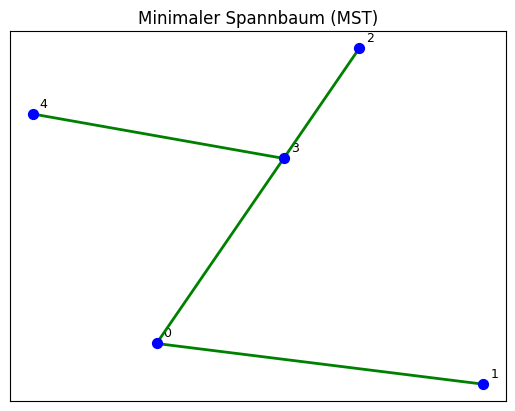

MST-Kanten (Indexpaare): [(0, 3), (3, 2), (3, 4), (0, 1)]


In [19]:
def plot_mst(mst_edges):
    """Visualisiert den minimalen Spannbaum (MST) im Vergleich zu den ursprünglichen Punkten.
    
    Parameter:
      mst_edges (list): Liste der MST-Kanten als Indexpaare (u, v).
    """
    plt.clf()
    # Erstelle einen Scatter-Plot für alle Punkte
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    plt.scatter(x_coords, y_coords, color='blue', zorder=5, s=50)
    
    # Beschrifte jeden Knoten mit seinem Index
    for i, (x, y) in enumerate(points):
        plt.annotate(str(i), (x, y), xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Zeichne die MST-Kanten ein
    for u, v in mst_edges:
        plt.plot([points[u][0], points[v][0]], [points[u][1], points[v][1]], 'g-', zorder=3, linewidth=2)
    
    plt.title("Minimaler Spannbaum (MST)")
    plt.grid(True, alpha=0.3)
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Berechne und visualisiere den MST für unsere Punktemenge
n = len(points)  # Anzahl der Punkte
mst_edges = compute_MST(n)
plot_mst(mst_edges)
print("MST-Kanten (Indexpaare):", mst_edges)

### 2. Identifikation von Knoten mit ungeradem Grad
Im nächsten Schritt müssen wir die Knoten finden, die im MST einen ungeraden Grad haben:

Der **Grad** eines Punktes ist die Anzahl der Verbindungen, die an diesem Punkt zusammenkommen. Wir suchen nach Punkten, bei denen eine ungerade Anzahl von Verbindungen zusammentrifft (1, 3, 5, usw.).

**Warum ist das wichtig?** Für den Eulerkreis, den wir später benötigen, müssen alle Punkte einen geraden Grad haben. Punkte mit ungeradem Grad bereiten Probleme, weil man beim Durchlaufen aller Verbindungen an ihnen "steckenbleiben" würde.

In der unten stehenden Visualisierung werden Knoten mit ungeradem Grad rot hervorgehoben.

In [20]:
def get_odd_vertices(mst_edges, n):
    """Ermittelt die Knoten im MST mit ungeradem Grad.
    
    Parameter:
      mst_edges (list): Liste der Kanten im MST, jedes Element ist ein Tupel (u, v).
      n (int): Anzahl der Knoten.
    
    Rückgabe:
      list: Liste der Knotenindizes mit ungeradem Grad.
    """
    degree = [0] * n   # Array zur Speicherung der Gradanzahl für jeden Knoten.
    
    # Für jede Kante im MST erhöhen wir den Grad beider beteiligter Knoten.
    for u, v in mst_edges:
        degree[u] += 1
        degree[v] += 1
    
    # Erstelle eine Liste aller Knoten, deren Grad ungerade ist.
    odd_vertices = [i for i in range(n) if degree[i] % 2 == 1]
    return odd_vertices

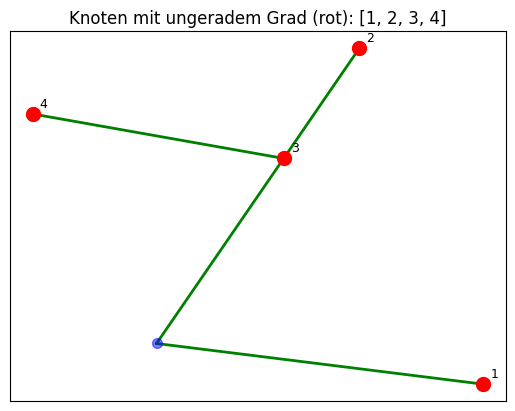

Knoten mit ungeradem Grad: [1, 2, 3, 4]


In [21]:
def plot_odd_vertices(mst_edges, odd_vertices):
    """Visualisiert den MST und hebt die Knoten mit ungeradem Grad hervor.
    
    Parameter:
      mst_edges (list): Liste der MST-Kanten als Indexpaare (u, v).
      odd_vertices (list): Liste der Knotenindizes mit ungeradem Grad.
    """
    plt.clf()
    # Erstelle einen Scatter-Plot für alle Punkte
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    plt.scatter(x_coords, y_coords, color='blue', zorder=3, s=50, alpha=0.5)
    
    # Zeichne die MST-Kanten ein
    for u, v in mst_edges:
        plt.plot([points[u][0], points[v][0]], [points[u][1], points[v][1]], 'g-', zorder=2, linewidth=2)
    
    # Hebe die Knoten mit ungeradem Grad hervor
    for i in odd_vertices:
        plt.scatter(points[i][0], points[i][1], color='red', s=100, zorder=5)
        plt.annotate(str(i), (points[i][0], points[i][1]), xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    plt.title(f"Knoten mit ungeradem Grad (rot): {odd_vertices}")
    plt.grid(True, alpha=0.3)
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Finde und visualisiere die Knoten mit ungeradem Grad
odd_vertices = get_odd_vertices(mst_edges, n)
plot_odd_vertices(mst_edges, odd_vertices)
print("Knoten mit ungeradem Grad:", odd_vertices)

### 3. Minimales perfektes Matching der Knoten mit ungeradem Grad

#### 3.1 Theoretisches Konzept

Das **perfekte Matching** ist ein grundlegender Baustein des Christofides-Algorithmus:

- Ein **Matching** in einem Graphen ist eine Teilmenge der Kanten, sodass keine zwei Kanten einen gemeinsamen Endknoten haben
- Ein **perfektes Matching** ist ein Matching, bei dem jeder Knoten des Graphen von genau einer Kante des Matchings berührt wird
- Ein **minimales perfektes Matching** minimiert die Summe der Kantengewichte über alle möglichen perfekten Matchings

In unserem Fall suchen wir ein minimales perfektes Matching für die Menge der Knoten mit ungeradem Grad.

#### 3.2 Implementierung

Für kleine Graphen können wir ein optimales Matching durch rekursives Backtracking finden. In der Praxis würde man für größere Graphen effizientere Algorithmen wie den "Blossom"-Algorithmus verwenden, der eine Laufzeit von O(n³) besitzt.

In [22]:
def min_weight_perfect_matching(odd_vertices):
    """Berechnet per rekursiver Backtracking-Suche das minimale perfekte Matching 
       der ungeraden Knoten.
    
    Parameter:
      odd_vertices (list): Liste der Knotenindizes mit ungeradem Grad.
    
    Rückgabe:
      list: Liste von Kanten (Tupel), die das Matching darstellen.
    """
    best_matching = None         # Variable zur Speicherung des besten Matching (mit minimalem Gesamtgewicht)
    best_weight = math.inf       # Initialisiere das beste Gewicht als unendlich
    
    # Rekursive Hilfsfunktion, um alle möglichen Matchings zu untersuchen
    def match_recursive(matching, unmatched, weight_so_far):
        nonlocal best_matching, best_weight
        
        # Basisfall: Wenn keine ungematchten Knoten mehr vorhanden sind,
        # prüfen wir das gefundene Matching
        if not unmatched:
            if weight_so_far < best_weight:
                best_weight = weight_so_far
                best_matching = matching.copy()  # Speichere das aktuelle Matching als bestes gefundenes
            return
        
        # Wähle den ersten ungematchten Knoten
        i = unmatched[0]
        
        # Versuche, i mit jedem der verbleibenden ungematchten Knoten zu matchen
        for j in unmatched[1:]:
            # Berechne die Distanz zwischen Knoten i und j als Gewicht des Paares
            pair_weight = euclidean(i, j)
            
            # Erstelle eine Kopie der Liste der ungematchten Knoten und entferne i und j daraus
            new_unmatched = unmatched.copy()
            new_unmatched.remove(i)
            new_unmatched.remove(j)
            
            # Führe die rekursive Suche fort, indem das aktuelle Paar zum Matching hinzugefügt wird
            match_recursive(matching + [(i, j)], new_unmatched, weight_so_far + pair_weight)
    
    # Starte die rekursive Suche mit einem leeren Matching, allen ungematchten Knoten und null anfänglichem Gewicht
    match_recursive([], odd_vertices, 0)
    return best_matching

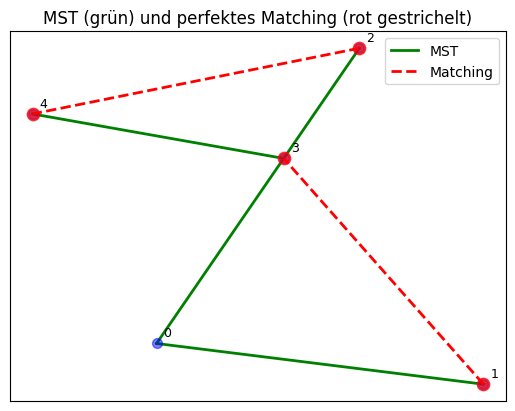

Perfektes Matching der Knoten mit ungeradem Grad: [(1, 3), (2, 4)]


In [23]:
def plot_matching(mst_edges, odd_vertices, matching):
    """Visualisiert den MST und das gefundene perfekte Matching.
    
    Parameter:
      mst_edges (list): Liste der MST-Kanten als Indexpaare (u, v).
      odd_vertices (list): Liste der Knotenindizes mit ungeradem Grad.
      matching (list): Liste der Matchingkanten als Indexpaare (u, v).
    """
    plt.clf()
    
    # Erstelle einen Scatter-Plot für alle Punkte
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    plt.scatter(x_coords, y_coords, color='blue', zorder=3, s=50, alpha=0.5)
    
    # Beschrifte jeden Knoten mit seinem Index
    for i, (x, y) in enumerate(points):
        plt.annotate(str(i), (x, y), xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Zeichne die MST-Kanten ein
    for u, v in mst_edges:
        plt.plot([points[u][0], points[v][0]], [points[u][1], points[v][1]], 'g-', zorder=2, linewidth=2, 
                 label="MST" if u == mst_edges[0][0] and v == mst_edges[0][1] else "")
    
    # Zeichne die Matching-Kanten ein
    for u, v in matching:
        plt.plot([points[u][0], points[v][0]], [points[u][1], points[v][1]], 'r--', zorder=4, linewidth=2, 
                 label="Matching" if u == matching[0][0] and v == matching[0][1] else "")
    
    # Hebe die Knoten mit ungeradem Grad hervor
    for i in odd_vertices:
        plt.scatter(points[i][0], points[i][1], color='red', s=80, zorder=5, alpha=0.7)
    
    plt.title("MST (grün) und perfektes Matching (rot gestrichelt)")
    plt.grid(True, alpha=0.3)
    plt.xticks([])
    plt.yticks([])
    plt.legend()
    plt.show()

# Berechne und visualisiere das perfekte Matching
matching = min_weight_perfect_matching(odd_vertices)
plot_matching(mst_edges, odd_vertices, matching)
print("Perfektes Matching der Knoten mit ungeradem Grad:", matching)

### 4. Erstellung eines Multigraphen

#### 4.1 Konzept des Multigraphen

Nachdem wir den MST und das minimale perfekte Matching berechnet haben, kombinieren wir diese zu einem **Multigraphen**:

- Ein **Multigraph** erlaubt mehrere Kanten zwischen denselben Knoten
- Wir vereinigen die Kantenmenge des MST mit der Kantenmenge des Matchings
- Dadurch haben nun alle Knoten einen **geraden Grad**

Nach Eulers Theorem enthält ein Graph genau dann einen **Eulerkreis**, wenn alle Knoten geraden Grad haben und der Graph zusammenhängend ist. Beide Bedingungen sind nun erfüllt.

In [24]:
def create_multigraph(n, mst_edges, matching):
    """Erstellt aus den MST-Kanten und dem Matching einen Multigraphen als Nachbarschaftsliste.
    
    Parameter:
      n (int): Anzahl der Knoten.
      mst_edges (list): Kanten des MST.
      matching (list): Kanten des perfekten Matchings.
    
    Rückgabe:
      dict: Dictionary, wobei jeder Schlüssel (Knotenindex) eine Liste von benachbarten Knoten hat.
    """
    # Initialisiere den Graphen als Dictionary mit leeren Nachbarschaftslisten
    graph = {i: [] for i in range(n)}
    
    # Füge alle MST-Kanten hinzu (in beide Richtungen, da ungerichtet)
    for u, v in mst_edges:
        graph[u].append(v)
        graph[v].append(u)
    
    # Füge alle Matching-Kanten hinzu (ebenfalls in beide Richtungen)
    for u, v in matching:
        graph[u].append(v)
        graph[v].append(u)
        
    return graph

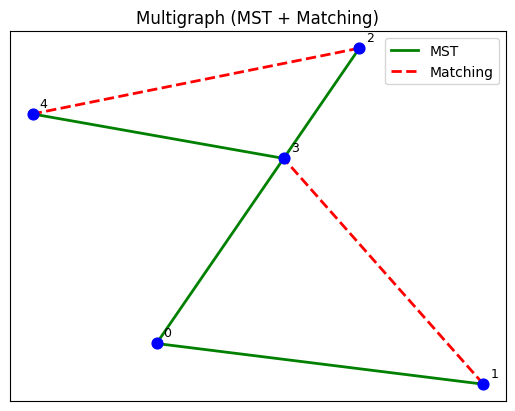

Multigraph als Nachbarschaftsliste:
Knoten 0: [3, 1]
Knoten 1: [0, 3]
Knoten 2: [3, 4]
Knoten 3: [0, 2, 4, 1]
Knoten 4: [3, 2]


In [25]:
def plot_multigraph(mst_edges, matching):
    """Visualisiert den Multigraphen, bestehend aus MST-Kanten und Matching-Kanten.
    
    Parameter:
      mst_edges (list): Liste der MST-Kanten als Indexpaare (u, v).
      matching (list): Liste der Matchingkanten als Indexpaare (u, v).
    """
    plt.clf()
    
    # Erstelle einen Scatter-Plot für alle Punkte
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    plt.scatter(x_coords, y_coords, color='blue', zorder=5, s=60)
    
    # Beschrifte jeden Knoten mit seinem Index
    for i, (x, y) in enumerate(points):
        plt.annotate(str(i), (x, y), xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Zeichne die MST-Kanten ein
    for u, v in mst_edges:
        plt.plot([points[u][0], points[v][0]], [points[u][1], points[v][1]], 'g-', zorder=2, linewidth=2, 
                 label="MST" if u == mst_edges[0][0] and v == mst_edges[0][1] else "")
    
    # Zeichne die Matching-Kanten ein
    if matching:
        for u, v in matching:
            plt.plot([points[u][0], points[v][0]], [points[u][1], points[v][1]], 'r--', zorder=3, linewidth=2, 
                     label="Matching" if u == matching[0][0] and v == matching[0][1] else "")
    
    plt.title("Multigraph (MST + Matching)")
    plt.grid(True, alpha=0.3)
    plt.xticks([])
    plt.yticks([])
    plt.legend()
    plt.show()

# Erstelle und visualisiere den Multigraphen
multigraph = create_multigraph(n, mst_edges, matching)
plot_multigraph(mst_edges, matching)

print("Multigraph als Nachbarschaftsliste:")
for node, neighbors in multigraph.items():
    print(f"Knoten {node}: {neighbors}")

### 5. Berechnung eines Eulerkreises

#### 5.1 Definition und Bedeutung

Ein **Eulerkreis** ist ein geschlossener Rundweg, der jede **Kante** des Graphen genau einmal durchläuft. Die Existenz eines Eulerkreises ist durch die Konstruktion unseres Multigraphen garantiert, da alle Knoten geraden Grad haben.

#### 5.2 Hierholzer-Algorithmus

Der **Hierholzer-Algorithmus** ist ein effizienter Algorithmus zur Berechnung eines Eulerkreises:

1. Beginne mit einem beliebigen Knoten und folge einem Pfad, wobei jede benutzte Kante gelöscht wird
2. Fahre fort, bis ein geschlossener Rundweg entsteht (Kreislauf)
3. Solange der Kreislauf noch nicht alle Kanten enthält:
   - Wähle einen Knoten des Kreislaufs, der noch ausgehende Kanten hat
   - Erzeuge von diesem Knoten aus einen neuen Kreislauf
   - Verschmelze diesen neuen Kreislauf mit dem bestehenden

In [26]:
def find_eulerian_tour(graph):
    """Findet mit Hierholzer-Algorithmus einen eulerischen Rundgang im gegebenen Graphen.
    
    Parameter:
      graph (dict): Nachbarschaftsliste des Graphen.
    
    Rückgabe:
      list: Liste der Knoten, die den eulerischen Rundgang in der berechneten Reihenfolge darstellen.
    """
    # Erstelle eine Kopie des Graphen, um die Originalstruktur nicht zu verändern
    graph_copy = {u: graph[u].copy() for u in graph}
    tour = []    # Liste zum Speichern des Eulerkreises
    stack = [0]  # Startpunkt des Rundgangs ist Knoten 0
    
    # Solange es noch Knoten im Stack gibt, wird der Algorithmus fortgesetzt
    while stack:
        u = stack[-1]  # Aktueller Knoten ist der oberste auf dem Stack
        
        if graph_copy[u]:  # Wenn der Knoten noch unbesuchte Nachbarn hat
            # Wähle einen Nachbarn und "besuche" diese Kante
            v = graph_copy[u].pop()
            stack.append(v)          
            
            # Entferne die Rückkante (v, u) aus dem Graphen (ungerichteter Graph)
            graph_copy[v].remove(u)
        else:
            # Wenn keine unbesuchten Kanten mehr vorhanden sind, füge den Knoten dem Eulerkreis hinzu
            tour.append(stack.pop())
    
    # Die Rückgabe erfolgt in der korrekten Reihenfolge des Rundgangs
    return tour[::-1]

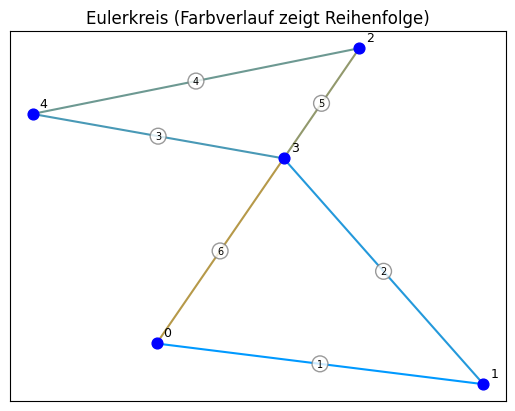

Eulerkreis (Knotenindizes): [0, 1, 3, 4, 2, 3, 0]
Länge des Eulerkreises: 7


In [27]:
def plot_eulerian_tour(eulerian_tour):
    """Visualisiert den gefundenen Eulerkreis.
    
    Parameter:
      eulerian_tour (list): Liste der Knoten des Eulerkreises.
    """
    plt.clf()
    
    # Erstelle einen Scatter-Plot für alle Punkte
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    plt.scatter(x_coords, y_coords, color='blue', zorder=5, s=60)
    
    # Beschrifte jeden Knoten mit seinem Index
    for i, (x, y) in enumerate(points):
        plt.annotate(str(i), (x, y), xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Zeichne den Eulerkreis mit Farbverlauf (früher = grün, später = rot)
    for i in range(len(eulerian_tour)-1):
        u = eulerian_tour[i]
        v = eulerian_tour[i+1]
        
        # Berechne Position der Knoten im Rundweg für die Farbgebung
        pos = i / len(eulerian_tour)
        color = (pos, 0.6, 1-pos)  # RGB-Farbverlauf von Grün nach Rot
        
        plt.plot([points[u][0], points[v][0]], [points[u][1], points[v][1]], 
                 color=color, zorder=2, linewidth=1.5)
        
        # Markiere die Reihenfolge der Kanten im Eulerkreis
        mid_x = (points[u][0] + points[v][0]) / 2
        mid_y = (points[u][1] + points[v][1]) / 2
        plt.annotate(str(i+1), (mid_x, mid_y), fontsize=7, ha='center', va='center',
                     bbox=dict(boxstyle="circle", fc="white", ec="gray", alpha=0.8))
    
    plt.title("Eulerkreis (Farbverlauf zeigt Reihenfolge)")
    plt.grid(True, alpha=0.3)
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Berechne und visualisiere den Eulerkreis
eulerian_tour = find_eulerian_tour(multigraph)
plot_eulerian_tour(eulerian_tour)
print("Eulerkreis (Knotenindizes):", eulerian_tour)
print("Länge des Eulerkreises:", len(eulerian_tour))

### 6. Umwandlung des Eulerkreises in einen Hamiltonkreis

#### 6.1 Vom Eulerkreis zum Hamiltonkreis

Der gefundene **Eulerkreis** besucht jede **Kante** genau einmal, kann dabei aber **Knoten** mehrfach besuchen. Für unsere TSP-Lösung benötigen wir einen **Hamiltonkreis**, der jeden Knoten genau einmal besucht.

Die Umwandlung erfolgt durch das sogenannte **Shortcutting**:

1. Wir durchlaufen den Eulerkreis in der berechneten Reihenfolge
2. Wir nehmen einen Knoten in unseren Hamiltonkreis auf, wenn wir ihn zum ersten Mal besuchen
3. Alle weiteren Besuche desselben Knotens werden übersprungen

In [28]:
def shortcut_eulerian(tour):
    """Umwandlung eines eulerischen Rundgangs in einen Hamiltonkreis durch Überspringen wiederholter Knoten.
    
    Parameter:
      tour (list): Liste der Knoten des Eulerkreises.
    
    Rückgabe:
      list: Liste der Knoten des resultierenden Hamiltonkreises.
    """
    visited = set()  # Set zur Speicherung bereits besuchter Knoten
    path = []        # Liste zur Speicherung des Hamiltonkreises
    
    # Gehe die Reihenfolge der Knoten im Eulerkreis durch
    for vertex in tour:
        # Nur Knoten hinzufügen, die noch nicht besucht wurden
        if vertex not in visited:
            visited.add(vertex)
            path.append(vertex)
    
    # Schließe den Kreis, indem der Startknoten wieder angehängt wird
    path.append(path[0])
    return path

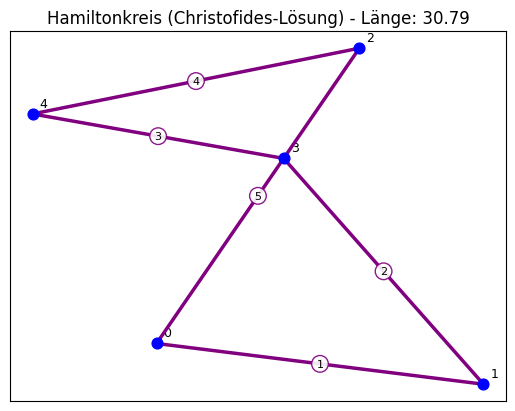

Hamiltonkreis (Knotenindizes): [0, 1, 3, 4, 2, 0]
Anzahl der Knoten im Hamiltonkreis: 6


In [29]:
def plot_hamiltonian(hamiltonian):
    """Visualisiert den resultierenden Hamiltonkreis.
    
    Parameter:
      hamiltonian (list): Liste der Knoten des Hamiltonkreises.
    """
    plt.clf()
    
    # Erstelle einen Scatter-Plot für alle Punkte
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    plt.scatter(x_coords, y_coords, color='blue', zorder=5, s=60)
    
    # Beschrifte jeden Knoten mit seinem Index
    for i, (x, y) in enumerate(points):
        plt.annotate(str(i), (x, y), xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Zeichne den Hamiltonkreis
    for i in range(len(hamiltonian)-1):
        u = hamiltonian[i]
        v = hamiltonian[i+1]
        plt.plot([points[u][0], points[v][0]], [points[u][1], points[v][1]], 'purple', zorder=3, linewidth=2.5)
        
        # Markiere die Reihenfolge der Kanten
        mid_x = (points[u][0] + points[v][0]) / 2
        mid_y = (points[u][1] + points[v][1]) / 2
        plt.annotate(str(i+1), (mid_x, mid_y), fontsize=8, ha='center', va='center',
                     bbox=dict(boxstyle="circle", fc="white", ec="purple", alpha=0.9))
    
    # Berechne die Gesamtlänge der Route
    hamilton_points = [points[i] for i in hamiltonian]
    total_distance = sum(math.dist(hamilton_points[i], hamilton_points[i+1]) for i in range(len(hamilton_points)-1))
    
    plt.title(f"Hamiltonkreis (Christofides-Lösung) - Länge: {total_distance:.2f}")
    plt.grid(True, alpha=0.3)
    plt.xticks([])
    plt.yticks([])
    plt.savefig("christofides.png", dpi=300, format="png", bbox_inches="tight")
    plt.show()

# Berechne und visualisiere den Hamiltonkreis
hamiltonian = shortcut_eulerian(eulerian_tour)
plot_hamiltonian(hamiltonian)
print("Hamiltonkreis (Knotenindizes):", hamiltonian)
print("Anzahl der Knoten im Hamiltonkreis:", len(hamiltonian))

### 7. Vollständige Christofides-Implementierung

Für eine vollständige Implementierung des Christofides-Algorithmus fassen wir die einzelnen Schritte zusammen:

Christofides-Algorithmus - Route-Länge: 30.79
Berechnungszeit: 0.000000 Sekunden
Anzahl der Distanzberechnungen: 16

--- DETAILLIERTE ROUTE DES CHRISTOFIDES-ALGORITHMUS ---
Reihenfolge der besuchten Punkte mit exakten Koordinaten:

Punkt 0: (3.7454, 1.5599)
Punkt 1: (9.5071, 0.5808)
Punkt 2: (5.9866, 6.0112)
Punkt 3: (1.5602, 7.0807)
Punkt 4: (7.3199, 8.6618)
Punkt 5: (3.7454, 1.5599)

Gesamtdistanz der Route: 30.7933


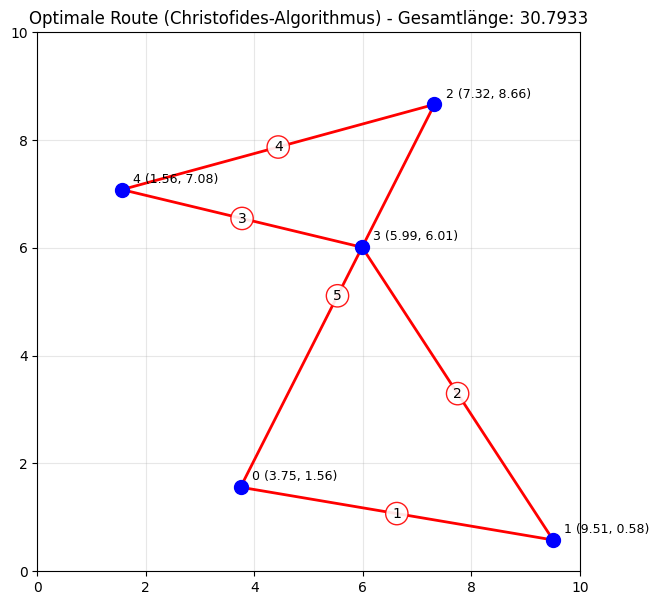

In [ ]:
def christofides_route():
    """Implementiert den vollständigen Christofides-Algorithmus und gibt die berechnete Route zurück."""
    
    global christofides_operations
    christofides_operations = 0  # Zurücksetzen des Zählers
    
    # Startzeit messen
    start_time = time.time()
    
    # Schritt 1: MST berechnen
    n = len(points)
    mst_edges = compute_MST(n)
    
    # Schritt 2: Knoten mit ungeradem Grad identifizieren
    odd_vertices = get_odd_vertices(mst_edges, n)
    
    # Schritt 3: Minimales perfektes Matching der ungeraden Knoten
    matching = min_weight_perfect_matching(odd_vertices)
    
    # Schritt 4: Multigraph erstellen
    multigraph = create_multigraph(n, mst_edges, matching)
    
    # Schritt 5: Eulerkreis finden
    eulerian_tour = find_eulerian_tour(multigraph)
    
    # Schritt 6: Hamiltonkreis ableiten
    hamiltonian = shortcut_eulerian(eulerian_tour)
    
    # Berechne die Koordinaten der Route und die Gesamtdistanz
    route_coords = [points[i] for i in hamiltonian]
    total_distance = sum(math.dist(route_coords[i], route_coords[i+1]) 
                        for i in range(len(route_coords)-1))
    
    # Endzeit messen
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Speichere Ergebnisse
    algorithm_results['christofides']['distance'] = total_distance
    algorithm_results['christofides']['time'] = execution_time
    algorithm_results['christofides']['operations'] = christofides_operations
    
    print(f"Christofides-Algorithmus - Route-Länge: {total_distance:.2f}")
    print(f"Berechnungszeit: {execution_time:.6f} Sekunden")
    print(f"Anzahl der Distanzberechnungen: {christofides_operations}")
    
    return route_coords, total_distance

# Führe den Christofides-Algorithmus aus
christofides_route_coords, christofides_distance = christofides_route()

# Detaillierte Ausgabe der kompletten Route mit exakten Koordinaten
print("\n--- DETAILLIERTE ROUTE DES CHRISTOFIDES-ALGORITHMUS ---")
print("Reihenfolge der besuchten Punkte mit exakten Koordinaten:\n")

for i, coord in enumerate(christofides_route_coords):
    print(f"Punkt {i}: ({coord[0]:.4f}, {coord[1]:.4f})")
    
print(f"\nGesamtdistanz der Route: {christofides_distance:.4f}")

# Visualisierung der finalen Route als Ganzes
plt.figure(figsize=(7, 7))
plt.scatter([p[0] for p in points], [p[1] for p in points], color='blue', s=100, zorder=5)

# Beschrifte jeden Knoten mit seinem Index
for i, (x, y) in enumerate(points):
    plt.annotate(f"{i} ({x:.2f}, {y:.2f})", (x, y), xytext=(8, 5), 
                 textcoords='offset points', fontsize=9)

# Zeichne die Route
for i in range(len(christofides_route_coords)-1):
    plt.plot([christofides_route_coords[i][0], christofides_route_coords[i+1][0]], 
             [christofides_route_coords[i][1], christofides_route_coords[i+1][1]], 
             'r-', linewidth=2, zorder=2)
    
    # Markiere die Reihenfolge der Kanten
    mid_x = (christofides_route_coords[i][0] + christofides_route_coords[i+1][0]) / 2
    mid_y = (christofides_route_coords[i][1] + christofides_route_coords[i+1][1]) / 2
    plt.annotate(str(i+1), (mid_x, mid_y), fontsize=10, ha='center', va='center',
                 bbox=dict(boxstyle="circle", fc="white", ec="red", alpha=0.9))

plt.title(f"Route (Christofides-Algorithmus) - Gesamtlänge: {christofides_distance:.4f}")
plt.grid(True, alpha=0.3)
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.show()

### 8. Theoretische Bewertung

Der Christofides-Algorithmus hat folgende Eigenschaften:

| Eigenschaft | Wert |
|------------|------|
| Zeitkomplexität | $O(n^3)$ |
| Approximationsgarantie | Faktor 3/2 (1.5) |
| Praktische Anwendbarkeit | Für mittelgroße bis große Instanzen mit gutem Kompromiss aus Qualität und Geschwindigkeit |

Insbesondere die garantierte Approximation von höchstens 50% über dem Optimum macht den Christofides-Algorithmus besonders wertvoll für praktische Anwendungen. Diese theoretische Garantie ist bis heute (mit kleineren Verbesserungen) der beste bekannte polynomielle Approximationsalgorithmus für das metrische TSP.